# 1. Import Libraries

In [112]:
import kagglehub
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, precision_score, recall_score, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline

import re
import nltk
import string
import os
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nlp_id.lemmatizer import Lemmatizer
from indoNLP.preprocessing import replace_slang, replace_word_elongation
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, GRU, Dropout, Reshape
import tensorflow as tf
import tensorflow_hub as tf_hub
import warnings

# 2. Data Loading

In [3]:
# Download dataset
dataset = kagglehub.dataset_download("ucupsedaya/gojek-app-reviews-bahasa-indonesia")

print("Path to dataset files:", dataset)

Path to dataset files: C:\Users\User\.cache\kagglehub\datasets\ucupsedaya\gojek-app-reviews-bahasa-indonesia\versions\2


In [4]:
path = r"C:\Users\User\.cache\kagglehub\datasets\ucupsedaya\gojek-app-reviews-bahasa-indonesia\versions\2\GojekAppReviewV4.0.0-V4.9.3_Cleaned.csv"
data = pd.read_csv(path)
data.head(5)

,userName,content,score,at,appVersion
0,Yuga Edit,akun gopay saya di blok,1,2022-01-21 10:52:12,4.9.3
1,ff burik,Lambat sekali sekarang ini bosssku apk gojek g...,3,2021-11-30 15:40:38,4.9.3
2,Anisa Suci Rahmayuliani,Kenapa sih dari kemarin sy buka aplikasi gojek...,4,2021-11-29 22:58:12,4.9.3
3,naoki yakuza,Baru download gojek dan hape baru trus ditop u...,1,2022-09-03 15:21:17,4.9.3
4,Trio Sugianto,Mantap,5,2022-01-15 10:05:27,4.9.3


# 3. Exploratory Data Analysis (EDA)

## 3.1 Dataset Details

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225002 entries, 0 to 225001
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   userName    225002 non-null  object
 1   content     225000 non-null  object
 2   score       225002 non-null  int64 
 3   at          225002 non-null  object
 4   appVersion  225002 non-null  object
dtypes: int64(1), object(4)
memory usage: 8.6+ MB


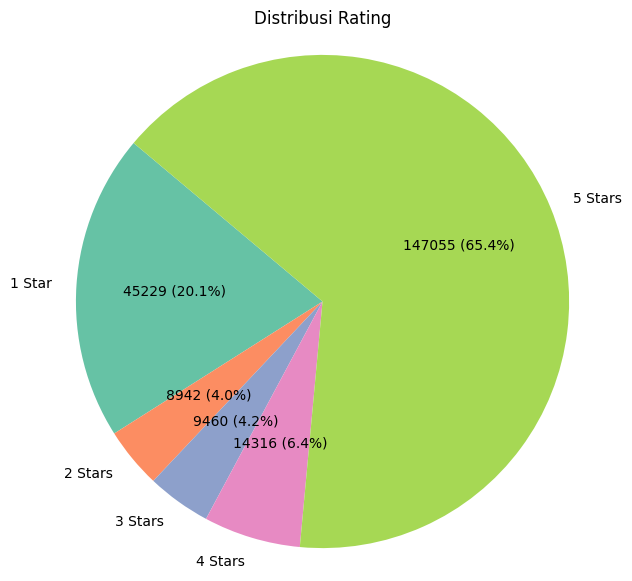

In [15]:
# Menghitung frekuensi masing-masing rating
rating_counts = data['score'].value_counts().sort_index()

# Label untuk setiap rating
rating_labels = ['1 Star', '2 Stars', '3 Stars', '4 Stars', '5 Stars']

# Membuat fungsi untuk menampilkan jumlah dan persentase
def autopct_func(pct, allvalues):
    absolute = round(pct / 100.*sum(allvalues), 0)
    return f"{int(absolute)} ({pct:.1f}%)"

# Membuat pie chart
plt.figure(figsize=(7, 7))
plt.pie(rating_counts, labels=rating_labels, autopct=lambda pct: autopct_func(pct, rating_counts), startangle=140, colors=sns.color_palette("Set2", 5))
plt.title('Distribusi Rating')
plt.axis('equal')  # Untuk memastikan pie chart berbentuk lingkaran
plt.show()

# 4. Feature Engineering

In [21]:
# Mengabaikan semua peringatan
warnings.filterwarnings("ignore")

In [10]:
# check data duplicate
data.duplicated().sum()

0

In [11]:
# remove unused column
df = data.drop(columns=['userName', 'at'])

In [22]:
# Menambahkan kolom 'label' berdasarkan nilai score
df['label'] = df['score'].apply(lambda x: 'negative' if x in [1, 2] else ('positive' if x in [4, 5] else None))

# Menghapus baris dengan score = 3
df = df[df['score'] != 3]

In [23]:
df.head()

,content,score,appVersion,label
0,akun gopay saya di blok,1,4.9.3,negative
2,Kenapa sih dari kemarin sy buka aplikasi gojek...,4,4.9.3,positive
3,Baru download gojek dan hape baru trus ditop u...,1,4.9.3,negative
4,Mantap,5,4.9.3,positive
5,Bagus,4,4.9.3,positive


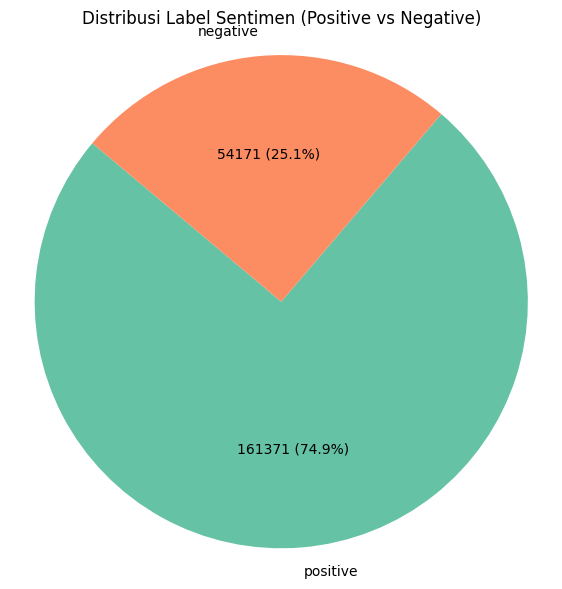

In [27]:
# Hitung distribusi label (positive vs negative)
label_counts = df['label'].value_counts()

# Fungsi untuk menampilkan jumlah dan persentase
def autopct_func(pct, allvals):
    absolute = round(pct / 100. * sum(allvals), 0)
    return f"{int(absolute)} ({pct:.1f}%)"

# Membuat pie chart untuk distribusi positive dan negative
plt.figure(figsize=(7, 7))
plt.pie(label_counts, labels=label_counts.index, autopct=lambda pct: autopct_func(pct, label_counts), startangle=140, colors=sns.color_palette("Set2", 2))
plt.title('Distribusi Label Sentimen (Positive vs Negative)')
plt.axis('equal')  # Untuk memastikan pie chart berbentuk lingkaran
plt.show()

In [45]:
# Define Stopwords
stpwds_id = list(set(stopwords.words('indonesian')))

# Define Stemming
stemmer = StemmerFactory().create_stemmer()

# Inisialisasi lemmatizer
lemmatizer = Lemmatizer()

In [51]:
def text_preprocessing(text):
    if not isinstance(text, str):  # Pastikan input adalah string
        return ""

    # Ganti slang terlebih dahulu
    text = replace_slang(text)

    # Ganti elongasi kata (contoh: 'ssuuuuper' menjadi 'super')
    text = replace_word_elongation(text)
    
    # Case folding: mengubah semua huruf menjadi kecil
    text = text.lower()

    # Menghapus mention (contoh: @username)
    text = re.sub(r"@[A-Za-z0-9_]+", " ", text)

    # Menghapus username (dalam kasus ini, 'username' dihapus)
    text = re.sub(r'username', '', text)

    # Menghapus hashtag (contoh: #hashtag)
    text = re.sub(r"#[A-Za-z0-9_]+", " ", text)

    # Menghapus newline
    text = re.sub(r"\n", " ", text)

    # Menghapus URL
    text = re.sub(r"http\S+|www\S+", " ", text)

    # Menghapus karakter non-huruf (hanya huruf dan spasi yang diperbolehkan)
    text = re.sub(r"[^A-Za-z\s']", " ", text)

    # Tokenisasi
    tokens = word_tokenize(text)

    # Menghapus stopwords
    tokens = [word for word in tokens if word not in stpwds_id]

    # Lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Menggabungkan kembali tokens menjadi satu teks
    text = ' '.join(tokens)

    return text

In [52]:
# Applying Text Preprocessing to the Dataset

df['text_processed'] = df['content'].apply(lambda x: text_preprocessing(x))
df

,content,score,appVersion,label,text_processed
0,akun gopay saya di blok,1,4.9.3,negative,akun gopay blok
2,Kenapa sih dari kemarin sy buka aplikasi gojek...,4,4.9.3,positive,sih kemarin buka aplikasi gojek kasih bintang ...
3,Baru download gojek dan hape baru trus ditop u...,1,4.9.3,negative,download gojek hape top lu gopay transaksi dia...
4,Mantap,5,4.9.3,positive,mantap
5,Bagus,4,4.9.3,positive,bagus
...,...,...,...,...,...
224997,Gofood Biaya lain2ya gak ngotak mending hujan2...,1,4.0.0,negative,gofood biaya ya ngotak mending hujan an beli m...
224998,Yok lah,5,4.0.0,positive,yuk
224999,Sempurna,5,4.0.0,positive,sempurna
225000,GOJEK LAMA LAMA GAK JELAS LAGI PESEN MASA MAP...,1,4.0.0,negative,gojek pesan mapsnya hilang layar putih nama ke...


## 4. Splitting Traing & Test

In [132]:
# Membuat dataframe df_clean yang hanya berisi 3 kolom yang dibutuhkan
df_clean = df[['text_processed', 'score', 'label']]

In [133]:
# Encode label 'label' menjadi angka
le = LabelEncoder()
df_clean['label'] = le.fit_transform(df_clean['label'])

In [134]:
# Membagi data menjadi fitur (X) dan target (y)
X = df_clean[['text_processed', 'score']]
y = df_clean['label']

In [135]:
# splitting data untuk train dan test set
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

# 5. Modeling With Machine Learning

In [136]:
# 3. Membuat transformer terpisah untuk text dan numeric
text_transformer = Pipeline([
    ('tfidf', TfidfVectorizer())
])

numeric_transformer = Pipeline([
    ('scaler', StandardScaler())
])

In [114]:
# 4. Membuat preprocessor menggunakan ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('text', text_transformer, 'text_processed'),
        ('num', numeric_transformer, ['score'])
    ])

In [117]:
# Misalnya, preprocessor_no_scaling bisa seperti ini:
preprocessor_no_scaling = ColumnTransformer(
    transformers=[
        ('text', text_transformer, 'text_processed'),
        ('num', 'passthrough', ['score'])  # Langsung biarkan score tanpa scaling
    ])

pipelines = {
    'logistic_regression': ImbPipeline([
        ('preprocessor', preprocessor),
        ('sampling', RandomUnderSampler(random_state=42)),
        ('classifier', LogisticRegression(random_state=42))
    ]),

    'naive_bayes': ImbPipeline([
        ('preprocessor', preprocessor_no_scaling),  # Gunakan transformer tanpa scaling pada `score`
        ('sampling', RandomUnderSampler(random_state=42)),
        ('classifier', MultinomialNB())
    ]),

    'knn': ImbPipeline([
        ('preprocessor', preprocessor),
        ('sampling', RandomUnderSampler(random_state=42)),
        ('classifier', KNeighborsClassifier())
    ]),

    'svm': ImbPipeline([
        ('preprocessor', preprocessor),
        ('sampling', RandomUnderSampler(random_state=42)),
        ('classifier', SVC(random_state=42))
    ]),

    'random_forest': ImbPipeline([
        ('preprocessor', preprocessor),
        ('sampling', RandomUnderSampler(random_state=42)),
        ('classifier', RandomForestClassifier(random_state=42))
    ])
}

# 6. Model Evaluation

## 6.1 Classification Report

In [118]:
# 7. Training dan evaluasi
for name, pipeline in pipelines.items():
    print(f"\nTraining {name}...")
    
    # Fit
    pipeline.fit(X_train, y_train)
    
    # Predict
    y_pred = pipeline.predict(X_test)
    
    # Evaluate
    print(f"\nClassification Report for {name}:")
    print(classification_report(y_test, y_pred))


Training logistic_regression...

Classification Report for logistic_regression:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10675
           1       1.00      1.00      1.00     32434

    accuracy                           1.00     43109
   macro avg       1.00      1.00      1.00     43109
weighted avg       1.00      1.00      1.00     43109


Training naive_bayes...

Classification Report for naive_bayes:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93     10675
           1       0.98      0.97      0.98     32434

    accuracy                           0.97     43109
   macro avg       0.95      0.96      0.95     43109
weighted avg       0.97      0.97      0.97     43109


Training knn...

Classification Report for knn:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10675
           1       1.00      1.00      1.0

## 6.2 Confusion Matrix

Confusion Matrix for logistic_regression:
[[10675     0]
 [    0 32434]]
Confusion Matrix for naive_bayes:
[[10145   530]
 [  947 31487]]
Confusion Matrix for knn:
[[10675     0]
 [    0 32434]]
Confusion Matrix for svm:
[[10675     0]
 [    0 32434]]
Confusion Matrix for random_forest:
[[10673     2]
 [  745 31689]]


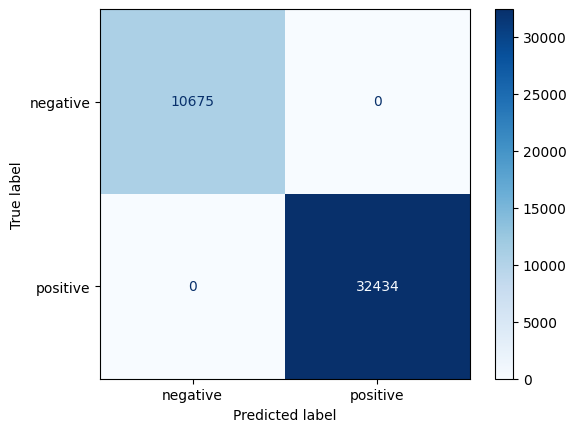

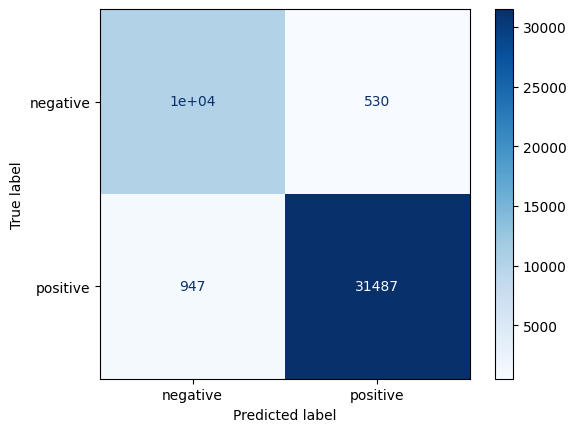

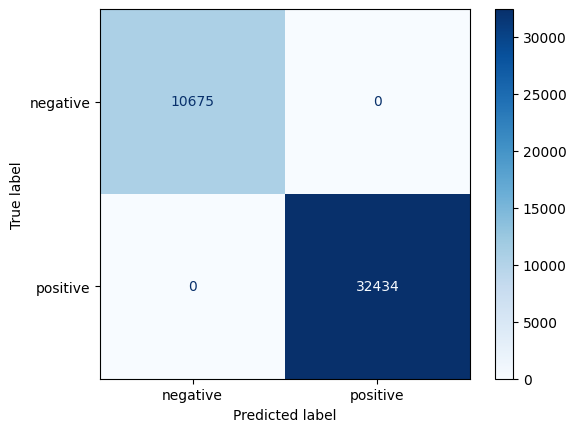

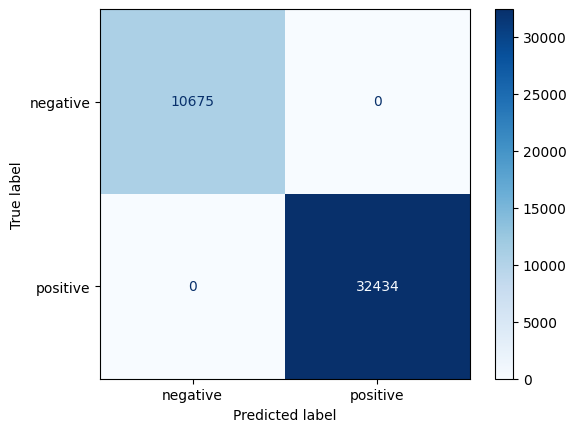

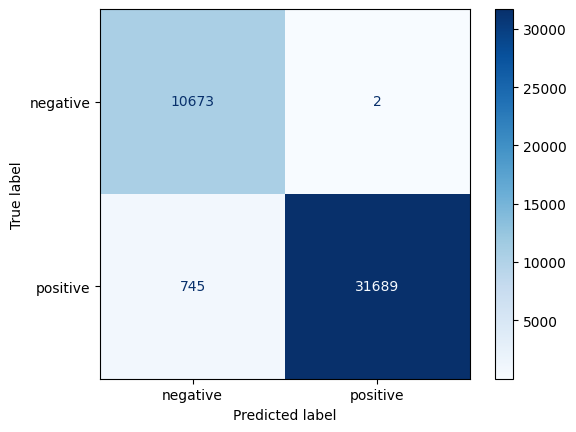

In [121]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Misalkan Anda memiliki pipelines yang sudah didefinisikan seperti 'logistic_regression' dan 'svm'
for model_name, pipeline in pipelines.items():
    # Fit model pada training set
    pipeline.fit(X_train, y_train)  # Pastikan untuk fit pipeline pada training data
    
    # Prediksi pada test set
    y_pred = pipeline.predict(X_test)  # Gunakan pipeline untuk melakukan prediksi
    
    # Hitung dan tampilkan confusion matrix
    cm = confusion_matrix(y_test, y_pred)  # Hitung confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)  # Menampilkan confusion matrix
    disp.plot(cmap='Blues')  # Plot confusion matrix dengan warna biru
    
    print(f"Confusion Matrix for {model_name}:")
    print(cm)

## 6.3 Cross-Validation

In [108]:
# # Membuat pipeline untuk model dan preprocessing
# # Di dalam pipeline, kita akan menggunakan TF-IDF untuk teks, scaling untuk 'score', 
# # dan RandomUnderSampler untuk under-sampling

# # 1. TF-IDF untuk 'text_processed'
# # 2. StandardScaler untuk 'score'
# # 3. Under-sampling untuk mengatasi imbalance
# # 4. Beberapa model machine learning: Logistic Regression, Naive Bayes, KNN, SVM, dan Random Forest

# # Membuat pipeline untuk Logistic Regression, Naive Bayes, KNN, SVM, dan Random Forest

# # Menyesuaikan StandardScaler untuk sparse matrix
# pipelines = {
#     'logistic_regression': ImbPipeline([
#         ('sampling', RandomUnderSampler(random_state=42)),
#         ('preprocessor', ColumnTransformer([
#             ('text', TfidfVectorizer(), 'text_processed'),  # TF-IDF untuk kolom text_processed
#             ('score', StandardScaler(with_mean=False), 'score')  # Scaling untuk kolom score dengan with_mean=False
#         ])),
#         ('clf', LogisticRegression(max_iter=1000, random_state=42))  # Logistic Regression
#     ]),
#     'naive_bayes': ImbPipeline([
#         ('sampling', RandomUnderSampler(random_state=42)),
#         ('preprocessor', ColumnTransformer([
#             ('text', TfidfVectorizer(), 'text_processed'),
#             ('score', StandardScaler(with_mean=False), 'score')  # Scaling untuk kolom score dengan with_mean=False
#         ])),
#         ('clf', MultinomialNB())  # Naive Bayes
#     ]),
#     'knn': ImbPipeline([
#         ('sampling', RandomUnderSampler(random_state=42)),
#         ('preprocessor', ColumnTransformer([
#             ('text', TfidfVectorizer(), 'text_processed'),
#             ('score', StandardScaler(with_mean=False), 'score')  # Scaling untuk kolom score dengan with_mean=False
#         ])),
#         ('clf', KNeighborsClassifier())  # K-Nearest Neighbors
#     ]),
#     'svm': ImbPipeline([
#         ('sampling', RandomUnderSampler(random_state=42)),
#         ('preprocessor', ColumnTransformer([
#             ('text', TfidfVectorizer(), 'text_processed'),
#             ('score', StandardScaler(with_mean=False), 'score')  # Scaling untuk kolom score dengan with_mean=False
#         ])),
#         ('clf', SVC(random_state=42))  # Support Vector Machine
#     ]),
#     'random_forest': ImbPipeline([
#         ('sampling', RandomUnderSampler(random_state=42)),
#         ('preprocessor', ColumnTransformer([
#             ('text', TfidfVectorizer(), 'text_processed'),
#             ('score', StandardScaler(with_mean=False), 'score')  # Scaling untuk kolom score dengan with_mean=False
#         ])),
#         ('clf', RandomForestClassifier(random_state=42))  # Random Forest
#     ])
# }

# 7. Model Inference

In [137]:
# Contoh data baru untuk inferensi
data_baru = pd.DataFrame({
    'text_processed': ['aplikasi bagus banget', 'gopay saya error terus', 'transaksi cepat dan mudah', 'gojek tolol banget, ga niat bikin aplikasi'],
    'score': [5, 1, 4, 5]
})

# Melakukan inferensi
X_baru = data_baru[['text_processed', 'score']]  # Data baru harus sesuai dengan format input

# Melakukan prediksi untuk setiap model dalam pipeline
for model_name, pipeline in pipelines.items():
    print(f"Prediksi menggunakan model: {model_name}")
    
    # Melakukan inferensi (prediksi) pada data baru
    y_pred_baru = pipeline.predict(X_baru)
    
    # Menampilkan hasil prediksi
    print(f"Hasil prediksi untuk {model_name}: {y_pred_baru}")
    
    # Mengonversi hasil prediksi ke label asli jika diperlukan
    y_pred_baru_label = le.inverse_transform(y_pred_baru)
    print(f"Hasil prediksi dengan label asli: {y_pred_baru_label}")
    print("\n")

Prediksi menggunakan model: logistic_regression
Hasil prediksi untuk logistic_regression: [1 0 1 1]
Hasil prediksi dengan label asli: ['positive' 'negative' 'positive' 'positive']


Prediksi menggunakan model: naive_bayes
Hasil prediksi untuk naive_bayes: [1 0 1 0]
Hasil prediksi dengan label asli: ['positive' 'negative' 'positive' 'negative']


Prediksi menggunakan model: knn
Hasil prediksi untuk knn: [1 0 1 1]
Hasil prediksi dengan label asli: ['positive' 'negative' 'positive' 'positive']


Prediksi menggunakan model: svm
Hasil prediksi untuk svm: [1 0 1 1]
Hasil prediksi dengan label asli: ['positive' 'negative' 'positive' 'positive']


Prediksi menggunakan model: random_forest
Hasil prediksi untuk random_forest: [1 0 1 0]
Hasil prediksi dengan label asli: ['positive' 'negative' 'positive' 'negative']




In [109]:
# # Melatih model dengan masing-masing pipeline dan evaluasi hasilnya
# for model_name, pipeline in pipelines.items():
#     print(f"\nTraining model: {model_name}")
    
#     # Melatih pipeline (gunakan X_train sebagai DataFrame 2D dengan dua kolom)
#     pipeline.fit(X_train[['text_processed', 'score']], y_train)  # X_train harus menjadi DataFrame 2D
    
#     # Prediksi pada data testing (gunakan X_test sebagai DataFrame 2D dengan dua kolom)
#     y_pred = pipeline.predict(X_test[['text_processed', 'score']])  # X_test harus menjadi DataFrame 2D
    
#     # Evaluasi model
#     print(f"Classification report for {model_name}:\n")
#     print(classification_report(y_test, y_pred))